In [1]:
import os
import sys
sys.path.insert(0, "../models/multimodal")

In [2]:
import torch
from pathlib import Path
from recommender import ImageRecommender
bin_root = Path("../models/multimodal/bin")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
recommender = ImageRecommender(bin_root/"model_22.pth", bin_root/"embedding.pkl")
recommender.to(device)

In [3]:
import pandas as pd

root = Path("../data")
df = pd.read_csv(root / "flickr8k/captions_test.txt").sample(1000).reset_index(drop=True)
df.head()

,image,caption
0,2872806249_00bea3c4e7.jpg,Woman in red overalls standing on the sidewalk .
1,465994762_1760e83c5d.jpg,Brown dog leaps over a chain suspended over a ...
2,2556392380_ee57514233.jpg,A boy in a robe sits in a chair .
3,230016181_0c52b95304.jpg,a woman wearing an orange jacket sitting in a ...
4,2081141788_38fa84ce3c.jpg,Three children jump into a hotel pool from an ...


In [5]:
from PIL import Image
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
image_path = Path(root / "flickr8k/images")

transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor()])

images = df["image"].unique()
image_tensors = list()
for image in images:
    image_tensors.append(transform(Image.open(image_path / image).convert("RGB")).to(device))

In [7]:
captions = df["caption"]
captions.head()

0     Woman in red overalls standing on the sidewalk .
1    Brown dog leaps over a chain suspended over a ...
2                    A boy in a robe sits in a chair .
3    a woman wearing an orange jacket sitting in a ...
4    Three children jump into a hotel pool from an ...
Name: caption, dtype: object

In [20]:
def caption_image(captions, img):
    img_vec = recommender.model.forward_cnn(img.unsqueeze(0)).squeeze(0)
    errors = torch.zeros(len(captions))
    for i, caption in enumerate(captions):
        embd_cap = recommender.vectorizer(caption).unsqueeze(1).to(device)
        cap_vec = recommender.model.forward_cap(embd_cap).squeeze(0)
        diff = img_vec - cap_vec
        errors[i] = -torch.dot(diff, diff)
    
    return torch.argmin(errors).item()    
        

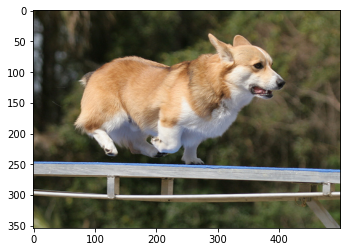

424379231_23f1ade134.jpg
A light brown and white dog walks on a thin railing .


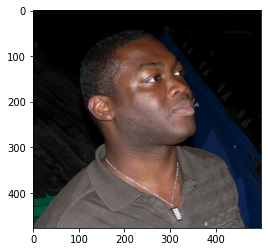

3005126574_49c28ffbee.jpg
Black man poses for photo .


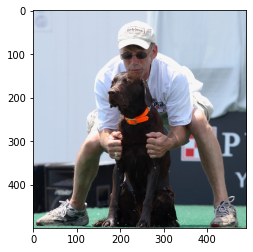

2451285022_59255e7fd9.jpg
A man in a white shirt is leaning over a brown dog in an orange collar .


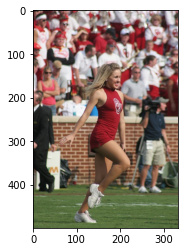

241345656_861aacefde.jpg
A woman in an red tracksuit squeezing lemons in a press .


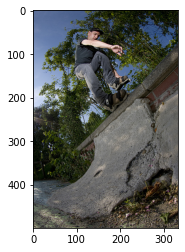

3728256505_7f8db8270d.jpg
A boy skateboards up a concrete ramp .


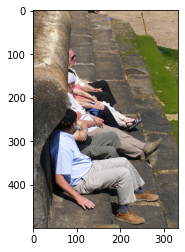

1763020597_d4cc8f0f8a.jpg
A man in blue sits on a wall with bags .


In [38]:
for img in images[62:68]:
    im = Image.open(image_path / img)
    tensor = transform(im.convert("RGB")).to(device)

    idx = caption_image(captions, tensor)
    plt.imshow(im)
    plt.show()
    print(img)
    print(captions[idx])